In [1]:
import jax

print("JAX version:", jax.__version__)
print("Backend:", jax.default_backend())
print("Devices:", jax.devices())

JAX version: 0.7.2
Backend: gpu
Devices: [CudaDevice(id=0)]


In [2]:
import jax.numpy as jnp
import numpy as np

precision = jnp.array([[1.4, 0.6],
                       [0.6, 1.8]], dtype=jnp.float32)
target_mean = jnp.array([1.0, -1.0], dtype=jnp.float32)

def log_prob(position):
    """Log-density up to a constant for the correlated Gaussian."""
    centered = position - target_mean
    return -0.5 * centered @ (precision @ centered)

def potential_energy(position):
    return -log_prob(position)

grad_U = jax.grad(potential_energy)

print("Potential at the mean:", float(potential_energy(target_mean)))
print("Gradient at the mean:", grad_U(target_mean))


Potential at the mean: 0.0
Gradient at the mean: [0. 0.]


In [3]:
from functools import partial
from jax import lax, random, jit

@jit
def leapfrog(position, momentum, step_size, num_steps):
    """One leapfrog trajectory consisting of num_steps full updates."""
    momentum = momentum - 0.5 * step_size * grad_U(position)

    def body(_, state):
        q, p = state
        q = q + step_size * p
        p = p - step_size * grad_U(q)
        return q, p

    position, momentum = lax.fori_loop(
        0, num_steps - 1, body, (position, momentum)
    )
    position = position + step_size * momentum
    momentum = momentum - 0.5 * step_size * grad_U(position)

    return position, -momentum  # flip momentum to make trajectories reversible

test_q = jnp.array([3.0, 3.0], dtype=jnp.float32)
test_p = jnp.array([0.2, -0.4], dtype=jnp.float32)
proposal_q, proposal_p = leapfrog(test_q, test_p, 0.3, 5)
print("Proposed q:", proposal_q)
print("Proposed p:", proposal_p)

Proposed q: [-0.42972934 -3.5671735 ]
Proposed p: [2.2304685 4.3425517]


In [4]:
@partial(jit, static_argnames=("num_steps",))
def hmc_step(rng_key, position, step_size, num_steps):
    """Single HMC transition using fresh momentum."""
    key_momentum, key_accept = random.split(rng_key)
    momentum = random.normal(key_momentum, shape=position.shape)

    proposal_q, proposal_p = leapfrog(position, momentum, step_size, num_steps)

    current_U = potential_energy(position)
    current_K = 0.5 * jnp.dot(momentum, momentum)
    proposed_U = potential_energy(proposal_q)
    proposed_K = 0.5 * jnp.dot(proposal_p, proposal_p)

    log_accept = current_U + current_K - proposed_U - proposed_K
    accept_prob = jnp.minimum(1.0, jnp.exp(log_accept))

    next_position = lax.cond(
        random.uniform(key_accept) < accept_prob,
        lambda _: proposal_q,
        lambda _: position,
        operand=None,
    )

    return next_position, accept_prob

In [5]:
@partial(jit, static_argnames=("num_samples", "num_steps"))
def run_chain(rng_key, initial_position, num_samples, step_size, num_steps):
    def transition(position, key):
        next_position, accept_prob = hmc_step(key, position, step_size, num_steps)
        return next_position, (next_position, accept_prob)

    keys = random.split(rng_key, num_samples)
    final_position, (positions, accept_probs) = lax.scan(
        transition, initial_position, keys
    )
    return positions, accept_probs

In [6]:
num_samples = 2000
num_warmup = 500
step_size = 0.28
num_steps = 5

rng_key = random.PRNGKey(8)
initial_position = jnp.array([3.0, 3.0], dtype=jnp.float32)

trajectory, accept_probs = run_chain(
    rng_key, initial_position, num_samples, step_size, num_steps
)

samples = np.array(trajectory[num_warmup:])
accept_rate = float(np.array(accept_probs[num_warmup:]).mean())
posterior_mean = samples.mean(axis=0)
posterior_cov = np.cov(samples, rowvar=False)

print("Acceptance rate:", round(accept_rate, 3))
print("Posterior mean:", posterior_mean)
print("Posterior covariance:\\n", posterior_cov)

Acceptance rate: 0.986
Posterior mean: [ 1.0221523 -1.0131464]
Posterior covariance:\n [[ 0.82281824 -0.2810567 ]
 [-0.2810567   0.65564375]]


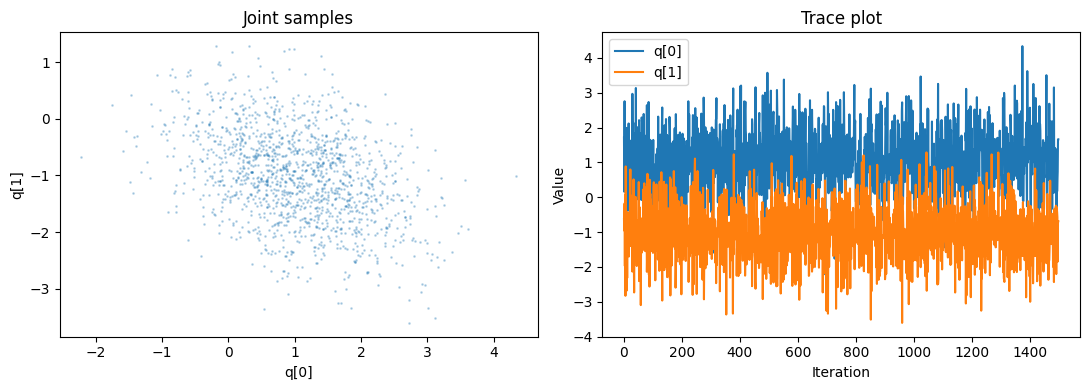

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].plot(samples[:, 0], samples[:, 1], ".", alpha=0.25, markersize=2)
axes[0].set_xlabel("q[0]")
axes[0].set_ylabel("q[1]")
axes[0].set_title("Joint samples")

axes[1].plot(samples[:, 0], label="q[0]")
axes[1].plot(samples[:, 1], label="q[1]")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Value")
axes[1].set_title("Trace plot")
axes[1].legend()

fig.tight_layout()
plt.show()